<a href="https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_10_4_captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image Captioning with Pytorch

The following contents are modified from MDS DSCI 575 lecture 8 demo

In [0]:
import os
import json
from collections import defaultdict
from tqdm import tqdm
import pickle
from time import time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from itertools import chain

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms, datasets
from torchsummary import summary
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import Dataset, DataLoader

from nltk.translate import bleu_score

START = "startseq"
STOP = "endseq"
EPOCHS = 10


In [0]:
# torch.cuda.empty_cache()
# import gc 
# model = None
# gc.collect()

The following function is used to nicely format elapsed times.

In [0]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"

### Google CoLab

If you are using Google CoLab then you will need to execute this cell.

In [5]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    root_captioning = "/content/drive/My Drive/data"
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Note: using Google CoLab


### Clean/Build Dataset

- Read captions
- Preprocess captions


In [0]:

set_names = ['rsicd', 'ucm', 'sydney']

def get_img_info(name, num):
    """
    Returns img paths and captions

    Parameters:
    -----------
    name: str
        the json file name
    num: int
        the number of observations to get

    Return:
    --------
    list, dict, int
        img paths, corresponding captions, max length of captions
    """
    img_path = []
    caption = [] 
    max_length = 0
    with open(root_captioning + '/processed/' + name + '.json', 'r') as json_data:
        data = json.load(json_data)
        for set_name in set_names:
            for filename in data[set_name].keys():
                if len(caption) == num:
                    break

                img_path.append(root_captioning + '/raw/imgs/'+ set_name + '/' + filename)
                sen_list = []
                for sentence in data[set_name][filename]['sentences']:
                    max_length = max(max_length, len(sentence['tokens']))
                    sen_list.append(sentence['raw'])

                caption.append(sen_list)
    
    return img_path, caption, max_length            


In [0]:
# get img path and caption list
# only test 800 train samples and 200 valid samples
train_img, train_descriptions, max_length_train = get_img_info('train', 800)
test_img, test_descriptions, max_length_test = get_img_info('valid', 200)
max_length = max(max_length_train, max_length_test)

      
lex = set()
for sen in train_descriptions:
  [lex.update(d.split()) for d in sen]

for sen in test_descriptions:
  [lex.update(d.split()) for d in sen]


Stats on what was collected.

In [8]:
print(len(train_descriptions)) # How many images? 
print(len(test_descriptions)) # How many images? 
print(len(lex)) # How many unique words (vocab)
print(max_length) # Maximum length of a caption (in words)


800
200
1147
32


## Load the images. 

Display the size of the train and test sets.

In [9]:
print(len(train_img))
print(len(test_img))

800
200


In [10]:
train_img[0]

'/content/drive/My Drive/data/raw/imgs/rsicd/church_212.jpg'

Build the sequences.  We include a **start** and **stop** token at the beginning/end.  We will later use the **start** token to begin the process of generating a caption.  Encountering the **stop** token in the generated text will let us know we are done.

In [0]:
for v in train_descriptions: 
  for d in range(len(v)):
    v[d] = f'{START} {v[d]} {STOP}'

See how many discriptions were extracted.

In [12]:
train_descriptions[0]

['startseq some buildings and many green trees are around a gray church . endseq',
 'startseq some buildings and many green trees are around a gray church . endseq',
 'startseq some buildings and many green trees are around a gray church . endseq',
 'startseq some buildings and many green trees are around a gray church . endseq',
 'startseq some buildings and many green trees are around a gray church . endseq']

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

In [0]:
class CNNModel(nn.Module):

  # def __init__(self, cnn_type, pretrained=True):
  def __init__(self, pretrained=True):
    super(CNNModel, self).__init__()
    # try:
    #   self.model = getattr(models, cnn_type)(pretrained=pretrained)
    # except:
    #   print(f'{cnn_type} is an invalid cnn structure.')
    self.model = models.vgg16(pretrained=pretrained)
    self.model.classifier = nn.Sequential(
        *list(self.model.classifier.children())[:-2]
        )
    self.model.to(device)

    self.input_size = 224

    # # inception v3 expects (299,299) sized images and has auxiliary output
    # if cnn_type.startswith('inception'):
    #   self.input_size = 299
    


In [16]:
encode_model = CNNModel()
# encode_model = CNNModel('vgg16')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


In [17]:
encode_model.model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [18]:
summary(encode_model.model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

### Creating the Training Set

We we need to encode the images to create the training set.  Later we will encode new images to present them for captioning.

We can how generate the training set.  This will involve looping over every JPG that was provied.  Because this can take awhile to perform we will save it to a pickle file.  This saves the considerable time needed to completly reprocess all of the images.  Because the images are processed differently by different transferred neural networks, the output dimensions are also made part of the file name.  If you changed from InceptionV3 to MobileNet, the number of output dimensions would change, and a new file would be created.

In [19]:
train_img[0]

'/content/drive/My Drive/data/raw/imgs/rsicd/church_212.jpg'

In [0]:
def encodeImage(image_path):
  img = Image.open(image_path)
  # Resize all images to a standard size (specified bythe image encoding network)
  img = img.resize((encode_model.input_size, encode_model.input_size), 
                   Image.ANTIALIAS)
  # Convert a PIL image to a numpy array
  # Perform preprocessing needed by pre-trained models
  preprocessor = transforms.Compose([
                                     transforms.Resize(encode_model.input_size),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225]
                                         )
                                     ])
  img = preprocessor(img)
  # Expand to 2D array
  img = img.view(1, *img.shape)
  # Call model to extract the smaller feature set for the image.
  with torch.no_grad():
    x = encode_model.model(img.to(device)) # Get the encoding vector for the image
  # Shape to correct form to be accepted by LSTM captioning network.
  x = np.squeeze(x)
  return x

In [0]:

train_path = os.path.join(root_captioning, f'train_pytorch.pkl')
if not os.path.exists(train_path):
  start = time()
  encoding_train = []
  for image_path in tqdm(train_img):
    encoding_train.append(encodeImage(image_path).cpu().data.numpy())
  with open(train_path, "wb") as fp:
    pickle.dump(encoding_train, fp)
  print(f"\nGenerating training set took: {hms_string(time()-start)}")
else:
  with open(train_path, "rb") as fp:
    encoding_train = pickle.load(fp)

In [22]:
len(encoding_train)

800

In [23]:
encoding_train[0]

array([0.        , 0.02014619, 0.        , ..., 0.        , 0.        ,
       0.        ], dtype=float32)

A similar process must also be performed for the test images.

In [0]:
test_path = os.path.join(root_captioning, f'test_pytorch.pkl')
if not os.path.exists(test_path):
  start = time()
  encoding_test = []
  for image_path in tqdm(test_img):
    encoding_test.append(encodeImage(image_path).cpu().data.numpy())
  with open(test_path, "wb") as fp:
    pickle.dump(encoding_test, fp)
  print(f"\nGenerating testing set took: {hms_string(time()-start)}")
else:
  with open(test_path, "rb") as fp:
    encoding_test = pickle.load(fp)

Next we separate the captions that will be using for training.  There are two sides to this training, the images and the captions.

In [25]:
all_train_captions = []
for val in train_descriptions:
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

4000

In [26]:
all_train_captions[0]

'startseq some buildings and many green trees are around a gray church . endseq'

Words that do not occur very often can be misleading to neural network training.  It is better to simply remove such words.  Here we remove any words that occur less than 10 times.  We display what the total vocabulary shrunk to.

In [27]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d ==> %d' % (len(word_counts), len(vocab)))

preprocessed words 1045 ==> 266


Next we build two lookup tables for this vocabulary. One idxtoword convers index numbers to actual words to index values.  The wordtoidx lookup table performs the opposit.

In [28]:
idxtoword = {}
wordtoidx = {}

ix = 1
for w in vocab:
    wordtoidx[w] = ix
    idxtoword[ix] = w
    ix += 1
    
vocab_size = len(idxtoword) + 1 
vocab_size

267

Previously we added a start and stop token to all sentences.  We must account for this in the maximum length of captions.

In [29]:
max_length +=2
print(max_length)

34


### Using a Data Generator

Up to this point we've always generated training data ahead of time and fit the neural network to it.  It is not always practical to generate all of the training data ahead of time.  The memory demands can be considerable.  If the training data can be generated, as the neural network needs it, it is possable to use a Keras generator.  The generator will create new data, as it is needed.  The generator provided here creates the training data for the caption neural network, as it is needed.

Here we are just training on two captions.  However, we would have to duplicate the image for each of these partial captions that we have. It is much more efficient to just generate the data as needed.

In [0]:
class SampleDataset(Dataset):
  def __init__(self, descriptions, photos, wordtoidx, max_length):
    self.photos = photos
    self.descriptions = descriptions
    self.wordtoidx = wordtoidx
    self.max_length = max_length

  def __len__(self):
    return len(self.photos)

  def __getitem__(self, idx):
    photo = self.photos[idx]
    x1, x2, caplens = [], [], []
    for desc in self.descriptions[idx]:
        # convert each word into a list of sequences.
        seq = [wordtoidx[word] for word in desc.split(' ')
               if word in self.wordtoidx]
        # pad the sequence with 0 on the right side
        in_seq = np.pad(seq, (0, max_length - len(seq)),
                        mode='constant', constant_values=(0, 0))

        x1.append(photo)
        x2.append(in_seq)
        caplens.append(len(seq)-1)
 
    return (x1, x2, caplens)


In [0]:
# class SampleDataset(Dataset):
#   def __init__(self, descriptions, photos, wordtoidx, max_length):
#     self.photos = photos
#     self.descriptions = descriptions
#     self.wordtoidx = wordtoidx
#     self.max_length = max_length

#   def __len__(self):
#     return len(self.photos)

#   def __getitem__(self, idx):

#     photo = self.photos[idx]
#     imgs, captions, caplens, targets = [], [], [], []
#     for desc in self.descriptions[idx]:
#         # convert each word into a list of sequences.
#         seq = [wordtoidx[word] for word in desc.split(' ')
#                if word in self.wordtoidx]

#         # Generate a training case for every possible sequence and outcome
#         for i in range(1, len(seq)):
#           in_seq, out_seq = seq[ : i], seq[1 : i + 1]
#           in_seq = np.pad(in_seq, (0, max_length - i),
#                           mode='constant', constant_values=(0, 0))
#           out_seq = np.pad(out_seq, (0, max_length - i),
#                           mode='constant', constant_values=(0, 0))
#           imgs.append(photo)
#           captions.append(in_seq)
#           targets.append(out_seq)
#           caplens.append(i)
 
#     return (imgs, captions, caplens, targets)


### Loading Glove Embeddings

In [33]:
embeddings_index = {} 
f = open(os.path.join(root_captioning, 'raw', 'glove.6B.200d.txt'), encoding="utf-8")

for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print(f'Found {len(embeddings_index)} word vectors.')

400000it [00:22, 17579.14it/s]

Found 400000 word vectors.


### Building the Neural Network

An embedding matrix is built from Glove.  This will be directly copied to the weight matrix of the neural network.

In [0]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoidx.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [35]:

embedding_matrix.shape

(267, 200)

The matrix makes sense.  It is 267 (the size of the vocabulary) by 200 (the number of features Glove generates for each word).




In [0]:
class RNNModel(nn.Module):

  def __init__(self, vocab_size, embedding_dim, feature_size, hidden_size):
    super(RNNModel, self).__init__()
    self.hidden_size = hidden_size
    self.vocab_size = vocab_size

    self.dropout1 = nn.Dropout(p=0.5)
    self.dense1 = nn.Linear(feature_size, hidden_size) 
    self.relu1 = nn.ReLU()

    self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

    self.dropout2 = nn.Dropout(p=0.5)
    # self.decode = nn.LSTM(embedding_dim + hidden_size, hidden_size)
    self.decode = nn.LSTM(embedding_dim, hidden_size)
      
    self.dense2 = nn.Linear(hidden_size, vocab_size) 


  def forward(self, encode_output, captions, caplens):

    encode = self.relu1(self.dense1(self.dropout1(encode_output)))

    batch_size = encode_output.size(0)  

    # embed and pack the captions
    embedding = self.dropout2(self.embedding(captions))

    embedding = pack_padded_sequence(embedding, caplens.cpu().numpy(), batch_first=True, enforce_sorted=False)

    outputs, _ = self.decode(embedding)
    outputs, _ = pad_packed_sequence(outputs, batch_first=True)
    
    outputs = self.dense2(outputs.add((encode.view(batch_size, 1, -1)).repeat(1, outputs.size(1), 1)))

    return outputs



In [0]:
# class RNNModel(nn.Module):

#   def __init__(self, vocab_size, embedding_dim, feature_size, hidden_size):
#     super(RNNModel, self).__init__()
#     self.hidden_size = hidden_size
#     self.vocab_size = vocab_size

#     self.dropout1 = nn.Dropout(p=0.5)
#     self.dense1 = nn.Linear(feature_size, hidden_size) 
#     self.relu1 = nn.ReLU()

#     self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

#     self.dropout2 = nn.Dropout(p=0.5)
#     # self.decode = nn.LSTM(embedding_dim + hidden_size, hidden_size)
#     self.decode = nn.LSTM(embedding_dim, hidden_size)
      
#     self.dense2 = nn.Linear(hidden_size, vocab_size) 
#     self.relu2 = nn.ReLU()
#     # self.dense3 = nn.Linear(hidden_size, vocab_size)  
#     # self.softmax = nn.Softmax(dim=2)


#   def forward(self, encode_output, captions, caplens):

#     encode = self.relu1(self.dense1(self.dropout1(encode_output)))

#     batch_size = encode_output.size(0)  

#     # embed and pack the captions
#     embedding = self.dropout2(self.embedding(captions))

#     embedding = pack_padded_sequence(embedding, caplens.cpu().numpy(), batch_first=True, enforce_sorted=False)

#     outputs, _ = self.decode(embedding)
#     outputs, input_sizes = pad_packed_sequence(outputs, batch_first=True)
    
#     outputs = self.dense2(outputs.add((encode.view(batch_size, 1, -1)).repeat(1, outputs.size(1), 1)))

#     return outputs



In [37]:
embedding_dim

200

In [38]:
len(encoding_train[0])

4096

### Train the Neural Network

In [0]:
def train(model, iterator, optimizer, criterion, clip):

    model.train()    
    epoch_loss = 0
    
    for encode_output, captions, caplens in iterator:
        
        optimizer.zero_grad()
        outputs = model(encode_output.to(device), captions[:, :-1].to(device), caplens.to(device))
        target= pack_padded_sequence(captions[:, 1:], caplens.cpu().numpy(), batch_first=True, enforce_sorted=False).data
        outputs = pack_padded_sequence(outputs, caplens.cpu().numpy(), batch_first=True, enforce_sorted=False).data
        # print(outputs.view(-1, 267).argmax(1))
        loss = criterion(outputs.view(-1, 267), target.to(device))
        epoch_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        
    return epoch_loss / len(iterator)

In [0]:
def my_collate(batch):
  
  encode_output = [item[0] for item in batch]
  captions = [item[1] for item in batch]
  caplens = [item[2] for item in batch]
  encode_output = torch.FloatTensor(list(chain(*encode_output)))
  captions = torch.LongTensor(list(chain(*captions)))
  caplens = torch.LongTensor(list(chain(*caplens)))
  # target = torch.FloatTensor(list(chain(*target)))
  return [encode_output, captions, caplens]

In [0]:
# def train(model, iterator, optimizer, criterion, clip):

#     model.train()    
#     epoch_loss = 0
    
#     for encode_output, captions, caplens, targets in iterator:
        
#         optimizer.zero_grad()
#         outputs = model(encode_output.to(device), captions.to(device), caplens.to(device))
#         targets= pack_padded_sequence(targets, caplens.cpu().numpy(), batch_first=True, enforce_sorted=False).data
#         outputs = pack_padded_sequence(outputs, caplens.cpu().numpy(), batch_first=True, enforce_sorted=False).data

#         loss = criterion(outputs.view(-1, 267), targets.to(device))
#         epoch_loss += loss.item()

#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
#         optimizer.step()
        
        
#     return epoch_loss / len(iterator)

In [0]:
# def my_collate(batch):
  
#   encode_output = []
#   captions = []
#   caplens = []
#   targets = []

#   for item in batch:
#     encode_output.append(item[0])
#     captions.append(item[1])
#     caplens.append(item[2])
#     targets.append(item[3])

#   encode_output = torch.FloatTensor(list(chain(*encode_output)))
#   captions = torch.LongTensor(list(chain(*captions)))
#   caplens = torch.LongTensor(list(chain(*caplens)))
#   targets = torch.LongTensor(list(chain(*targets)))

#   return [encode_output, captions, caplens, targets]

In [0]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            


In [83]:
caption_model = RNNModel(vocab_size, embedding_dim, len(encoding_train[0]), 256)
caption_model.apply(init_weights)

caption_model.embedding.load_state_dict({'weight': torch.FloatTensor(embedding_matrix)})
caption_model.embedding.requires_grad = False

PAD_IDX = 0
print('<pad> token index: ',PAD_IDX)
## we will ignore the pad token in true target set
# this does not work as expected
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

optimizer = torch.optim.Adam(caption_model.parameters(), lr=0.01)

train_dataset = SampleDataset(train_descriptions, encoding_train, wordtoidx, max_length)

train_loader = DataLoader(train_dataset, 200, collate_fn=my_collate)

<pad> token index:  0


In [85]:
clip = 1
caption_model.to(device)

model_path = os.path.join(root_captioning,f'caption-model_pytorch.hdf5')
if not os.path.exists(model_path):
  start = time()

  for i in tqdm(range(EPOCHS*10)):
      
    loss = train(caption_model, train_loader, optimizer, criterion, clip)
    print(loss)
 
  for param_group in optimizer.param_groups:
      param_group['lr'] = 1e-4

  for i in tqdm(range(EPOCHS*5)):

      loss = train(caption_model, train_loader, optimizer, criterion, clip)
      print(loss)
      
  torch.save(caption_model, model_path)
  print(f"\Training took: {hms_string(time()-start)}")

else:
  caption_model = torch.load(model_path)






  0%|          | 0/100 [00:00<?, ?it/s]



  1%|          | 1/100 [00:01<02:54,  1.76s/it]

1.6323768198490143






  2%|▏         | 2/100 [00:03<02:50,  1.74s/it]

1.488716036081314






  3%|▎         | 3/100 [00:05<02:47,  1.73s/it]

1.3795789182186127






  4%|▍         | 4/100 [00:06<02:44,  1.72s/it]

1.2868179380893707






  5%|▌         | 5/100 [00:08<02:42,  1.71s/it]

1.2047356963157654






  6%|▌         | 6/100 [00:10<02:40,  1.71s/it]

1.1364444494247437






  7%|▋         | 7/100 [00:11<02:39,  1.71s/it]

1.0771313607692719






  8%|▊         | 8/100 [00:13<02:37,  1.71s/it]

1.0212832242250443






  9%|▉         | 9/100 [00:15<02:34,  1.70s/it]

0.9770628213882446






 10%|█         | 10/100 [00:17<02:32,  1.70s/it]

0.9310783594846725






 11%|█         | 11/100 [00:18<02:31,  1.70s/it]

0.8933923095464706






 12%|█▏        | 12/100 [00:20<02:29,  1.70s/it]

0.8543253093957901






 13%|█▎        | 13/100 [00:22<02:27,  1.70s/it]

0.820762038230896






 14%|█▍        | 14/100 [00:23<02:26,  1.70s/it]

0.7893702238798141






 15%|█▌        | 15/100 [00:25<02:24,  1.71s/it]

0.7594267725944519






 16%|█▌        | 16/100 [00:27<02:22,  1.70s/it]

0.7334877103567123






 17%|█▋        | 17/100 [00:28<02:20,  1.70s/it]

0.7090952396392822






 18%|█▊        | 18/100 [00:30<02:19,  1.70s/it]

0.6892637461423874






 19%|█▉        | 19/100 [00:32<02:17,  1.70s/it]

0.6665102988481522






 20%|██        | 20/100 [00:34<02:16,  1.70s/it]

0.6447959989309311






 21%|██        | 21/100 [00:35<02:14,  1.70s/it]

0.6213001757860184






 22%|██▏       | 22/100 [00:37<02:13,  1.71s/it]

0.59807288646698






 23%|██▎       | 23/100 [00:39<02:11,  1.70s/it]

0.5785801559686661






 24%|██▍       | 24/100 [00:40<02:09,  1.70s/it]

0.5620076656341553






 25%|██▌       | 25/100 [00:42<02:08,  1.71s/it]

0.5465749129652977






 26%|██▌       | 26/100 [00:44<02:06,  1.71s/it]

0.5265205055475235






 27%|██▋       | 27/100 [00:45<02:03,  1.70s/it]

0.5126001685857773






 28%|██▊       | 28/100 [00:47<02:02,  1.70s/it]

0.5025117844343185






 29%|██▉       | 29/100 [00:49<02:00,  1.69s/it]

0.48624958097934723






 30%|███       | 30/100 [00:51<01:58,  1.69s/it]

0.47486143559217453






 31%|███       | 31/100 [00:52<01:57,  1.70s/it]

0.4611411988735199






 32%|███▏      | 32/100 [00:54<01:55,  1.69s/it]

0.45243871957063675






 33%|███▎      | 33/100 [00:56<01:54,  1.70s/it]

0.439751960337162






 34%|███▍      | 34/100 [00:57<01:52,  1.70s/it]

0.43263372778892517






 35%|███▌      | 35/100 [00:59<01:50,  1.70s/it]

0.41808728873729706






 36%|███▌      | 36/100 [01:01<01:49,  1.71s/it]

0.4087241366505623






 37%|███▋      | 37/100 [01:03<01:48,  1.71s/it]

0.40050058811903






 38%|███▊      | 38/100 [01:04<01:46,  1.71s/it]

0.39279231429100037






 39%|███▉      | 39/100 [01:06<01:44,  1.71s/it]

0.38453198224306107






 40%|████      | 40/100 [01:08<01:44,  1.74s/it]

0.37487301230430603






 41%|████      | 41/100 [01:09<01:42,  1.74s/it]

0.3701615408062935






 42%|████▏     | 42/100 [01:11<01:40,  1.73s/it]

0.3620207831263542






 43%|████▎     | 43/100 [01:13<01:38,  1.73s/it]

0.35219399631023407






 44%|████▍     | 44/100 [01:15<01:36,  1.73s/it]

0.35086672008037567






 45%|████▌     | 45/100 [01:16<01:35,  1.73s/it]

0.3421902731060982






 46%|████▌     | 46/100 [01:18<01:32,  1.72s/it]

0.33780384808778763






 47%|████▋     | 47/100 [01:20<01:30,  1.71s/it]

0.33315715193748474






 48%|████▊     | 48/100 [01:21<01:28,  1.71s/it]

0.3269136846065521






 49%|████▉     | 49/100 [01:23<01:26,  1.71s/it]

0.32277877628803253






 50%|█████     | 50/100 [01:25<01:25,  1.70s/it]

0.3188929110765457






 51%|█████     | 51/100 [01:27<01:23,  1.70s/it]

0.313711479306221






 52%|█████▏    | 52/100 [01:28<01:21,  1.69s/it]

0.3088466674089432






 53%|█████▎    | 53/100 [01:30<01:19,  1.69s/it]

0.3053961992263794






 54%|█████▍    | 54/100 [01:32<01:18,  1.71s/it]

0.30115455389022827






 55%|█████▌    | 55/100 [01:33<01:16,  1.71s/it]

0.2982667312026024






 56%|█████▌    | 56/100 [01:35<01:15,  1.71s/it]

0.29604707658290863






 57%|█████▋    | 57/100 [01:37<01:13,  1.71s/it]

0.29543623328208923






 58%|█████▊    | 58/100 [01:38<01:11,  1.70s/it]

0.28606193512678146






 59%|█████▉    | 59/100 [01:40<01:09,  1.70s/it]

0.2839233875274658






 60%|██████    | 60/100 [01:42<01:07,  1.70s/it]

0.28268126398324966






 61%|██████    | 61/100 [01:44<01:06,  1.69s/it]

0.2786076068878174






 62%|██████▏   | 62/100 [01:45<01:04,  1.69s/it]

0.2754116654396057






 63%|██████▎   | 63/100 [01:47<01:02,  1.70s/it]

0.2701706774532795






 64%|██████▍   | 64/100 [01:49<01:00,  1.69s/it]

0.27028003334999084






 65%|██████▌   | 65/100 [01:50<00:59,  1.69s/it]

0.26907748356461525






 66%|██████▌   | 66/100 [01:52<00:57,  1.69s/it]

0.26606906577944756






 67%|██████▋   | 67/100 [01:54<00:55,  1.69s/it]

0.26197393983602524






 68%|██████▊   | 68/100 [01:55<00:54,  1.69s/it]

0.26141592115163803






 69%|██████▉   | 69/100 [01:57<00:52,  1.70s/it]

0.25873954966664314






 70%|███████   | 70/100 [01:59<00:50,  1.70s/it]

0.2580289840698242






 71%|███████   | 71/100 [02:00<00:49,  1.69s/it]

0.2500910125672817






 72%|███████▏  | 72/100 [02:02<00:47,  1.70s/it]

0.2509653717279434






 73%|███████▎  | 73/100 [02:04<00:45,  1.70s/it]

0.2493206486105919






 74%|███████▍  | 74/100 [02:06<00:44,  1.70s/it]

0.24869294837117195






 75%|███████▌  | 75/100 [02:07<00:42,  1.70s/it]

0.24467876553535461






 76%|███████▌  | 76/100 [02:09<00:40,  1.70s/it]

0.24325666949152946






 77%|███████▋  | 77/100 [02:11<00:39,  1.70s/it]

0.24255485087633133






 78%|███████▊  | 78/100 [02:12<00:37,  1.70s/it]

0.24001024290919304






 79%|███████▉  | 79/100 [02:14<00:35,  1.70s/it]

0.2406737580895424






 80%|████████  | 80/100 [02:16<00:33,  1.70s/it]

0.23751651123166084






 81%|████████  | 81/100 [02:17<00:32,  1.70s/it]

0.23649390414357185






 82%|████████▏ | 82/100 [02:19<00:30,  1.70s/it]

0.23124082013964653






 83%|████████▎ | 83/100 [02:21<00:28,  1.70s/it]

0.23023585602641106






 84%|████████▍ | 84/100 [02:23<00:27,  1.72s/it]

0.23033931106328964






 85%|████████▌ | 85/100 [02:24<00:25,  1.72s/it]

0.2274145968258381






 86%|████████▌ | 86/100 [02:26<00:24,  1.72s/it]

0.22988473623991013






 87%|████████▋ | 87/100 [02:28<00:22,  1.72s/it]

0.22725144401192665






 88%|████████▊ | 88/100 [02:30<00:20,  1.71s/it]

0.22729115188121796






 89%|████████▉ | 89/100 [02:31<00:18,  1.71s/it]

0.22640352323651314






 90%|█████████ | 90/100 [02:33<00:17,  1.71s/it]

0.22524920478463173






 91%|█████████ | 91/100 [02:35<00:15,  1.71s/it]

0.22391967475414276






 92%|█████████▏| 92/100 [02:36<00:13,  1.70s/it]

0.22455742210149765






 93%|█████████▎| 93/100 [02:38<00:11,  1.70s/it]

0.2200821004807949






 94%|█████████▍| 94/100 [02:40<00:10,  1.70s/it]

0.22001953050494194






 95%|█████████▌| 95/100 [02:41<00:08,  1.70s/it]

0.21747588366270065






 96%|█████████▌| 96/100 [02:43<00:06,  1.69s/it]

0.2173704206943512






 97%|█████████▋| 97/100 [02:45<00:05,  1.70s/it]

0.2168990671634674






 98%|█████████▊| 98/100 [02:46<00:03,  1.69s/it]

0.2144479788839817






 99%|█████████▉| 99/100 [02:48<00:01,  1.70s/it]

0.21445877850055695






100%|██████████| 100/100 [02:50<00:00,  1.70s/it]




  0%|          | 0/50 [00:00<?, ?it/s]

0.2152615264058113






  2%|▏         | 1/50 [00:01<01:23,  1.71s/it]

0.2134687788784504






  4%|▍         | 2/50 [00:03<01:22,  1.72s/it]

0.2081349976360798






  6%|▌         | 3/50 [00:05<01:20,  1.72s/it]

0.20944372192025185






  8%|▊         | 4/50 [00:06<01:18,  1.72s/it]

0.20947354286909103






 10%|█         | 5/50 [00:08<01:16,  1.71s/it]

0.2066868580877781






 12%|█▏        | 6/50 [00:10<01:15,  1.71s/it]

0.20727386698126793






 14%|█▍        | 7/50 [00:11<01:13,  1.70s/it]

0.20752139016985893






 16%|█▌        | 8/50 [00:13<01:11,  1.70s/it]

0.20354018360376358






 18%|█▊        | 9/50 [00:15<01:09,  1.70s/it]

0.2060525231063366






 20%|██        | 10/50 [00:17<01:07,  1.70s/it]

0.20325490459799767






 22%|██▏       | 11/50 [00:18<01:06,  1.71s/it]

0.2034040056169033






 24%|██▍       | 12/50 [00:20<01:04,  1.70s/it]

0.2038370631635189






 26%|██▌       | 13/50 [00:22<01:02,  1.70s/it]

0.20249051600694656






 28%|██▊       | 14/50 [00:23<01:01,  1.70s/it]

0.2056683413684368






 30%|███       | 15/50 [00:25<00:59,  1.70s/it]

0.20305020734667778






 32%|███▏      | 16/50 [00:27<00:57,  1.69s/it]

0.20177989453077316






 34%|███▍      | 17/50 [00:28<00:55,  1.69s/it]

0.20056232810020447






 36%|███▌      | 18/50 [00:30<00:54,  1.69s/it]

0.20225391909480095






 38%|███▊      | 19/50 [00:32<00:52,  1.69s/it]

0.1996399201452732






 40%|████      | 20/50 [00:33<00:50,  1.69s/it]

0.20224940031766891






 42%|████▏     | 21/50 [00:35<00:48,  1.68s/it]

0.1998741216957569






 44%|████▍     | 22/50 [00:37<00:47,  1.68s/it]

0.20105576887726784






 46%|████▌     | 23/50 [00:39<00:45,  1.68s/it]

0.20242325216531754






 48%|████▊     | 24/50 [00:40<00:43,  1.69s/it]

0.20069286972284317






 50%|█████     | 25/50 [00:42<00:42,  1.69s/it]

0.20040276274085045






 52%|█████▏    | 26/50 [00:44<00:40,  1.69s/it]

0.20066765695810318






 54%|█████▍    | 27/50 [00:45<00:38,  1.69s/it]

0.19942697137594223






 56%|█████▌    | 28/50 [00:47<00:37,  1.69s/it]

0.19971460103988647






 58%|█████▊    | 29/50 [00:49<00:35,  1.70s/it]

0.1974816843867302






 60%|██████    | 30/50 [00:50<00:34,  1.71s/it]

0.19887636601924896






 62%|██████▏   | 31/50 [00:52<00:32,  1.71s/it]

0.19746723398566246






 64%|██████▍   | 32/50 [00:54<00:30,  1.71s/it]

0.20020661503076553






 66%|██████▌   | 33/50 [00:56<00:28,  1.70s/it]

0.19857047870755196






 68%|██████▊   | 34/50 [00:57<00:27,  1.71s/it]

0.19825857877731323






 70%|███████   | 35/50 [00:59<00:25,  1.71s/it]

0.1991545408964157






 72%|███████▏  | 36/50 [01:01<00:23,  1.70s/it]

0.19720273092389107






 74%|███████▍  | 37/50 [01:02<00:22,  1.70s/it]

0.19748065248131752






 76%|███████▌  | 38/50 [01:04<00:20,  1.70s/it]

0.19593071192502975






 78%|███████▊  | 39/50 [01:06<00:18,  1.69s/it]

0.1960405483841896






 80%|████████  | 40/50 [01:07<00:16,  1.69s/it]

0.19696885347366333






 82%|████████▏ | 41/50 [01:09<00:15,  1.69s/it]

0.19811861217021942






 84%|████████▍ | 42/50 [01:11<00:13,  1.69s/it]

0.19683808460831642






 86%|████████▌ | 43/50 [01:12<00:11,  1.69s/it]

0.19769031181931496






 88%|████████▊ | 44/50 [01:14<00:10,  1.69s/it]

0.19843170419335365






 90%|█████████ | 45/50 [01:16<00:08,  1.69s/it]

0.19790542498230934






 92%|█████████▏| 46/50 [01:18<00:06,  1.69s/it]

0.19927122816443443






 94%|█████████▍| 47/50 [01:19<00:05,  1.70s/it]

0.19363287091255188






 96%|█████████▌| 48/50 [01:21<00:03,  1.70s/it]

0.19533556699752808






 98%|█████████▊| 49/50 [01:23<00:01,  1.71s/it]

0.1938694715499878






100%|██████████| 50/50 [01:24<00:00,  1.70s/it]

0.1944916918873787
\Training took: 0:04:15.36



/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type RNNModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### Generating Captions

It is important to understand that a caption is not generated with one single call to the neural network's predict function.  Neural networks output a fixed-length tensor.  To get a variable length output, such as free-form text, requires multiple calls to the neural network.

The neural network accepts two objects (which are mapped to the input neurons).  The first is the photo.  The second is an ever growing caption.  The caption begins with just the starting token.  The neural network's output is the prediction of the next word in the caption.  This continues until an end token is predicted or we reach the maximum length of a caption.  Each time predict a new word is predicted for the caption.  The word that has the highest probability (from the neural network) is chosen. 

In [0]:
def generateCaption(photo):
    in_text = START
    for i in range(max_length):

        sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]
        sequence = np.pad(sequence, (0, max_length - len(sequence)),
                          mode='constant', constant_values=(0, 0))
        
        yhat = caption_model(
            torch.FloatTensor(encoding_test[0]).view(-1, 4096).to(device),
            torch.LongTensor(sequence).view(-1, max_length).to(device),
            torch.LongTensor([len(sequence)]).to(device)
            )

        yhat = yhat.view(-1, 267).argmax(1)
        word = idxtoword[yhat.cpu().data.numpy()[i]]
        in_text += ' ' + word
        if word == STOP:
            break
    final = in_text.split()
    final = final[1 : -1]
    final = ' '.join(final)
    return final

### Evaluate Performance on Test Data

The caption model performs relativly well on images that are similar to what it trained on.

/content/drive/My Drive/data/raw/imgs/rsicd/park_282.jpg


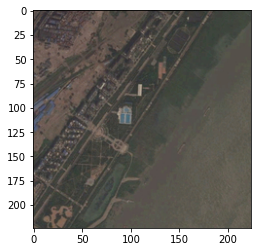

Human-annotated Caption:
 a park with some green plants and buildings is near a piece of water .
Generated Caption:
 the roads are the trees .
BLEU score: 0.6042750794713536
_____________________________________
/content/drive/My Drive/data/raw/imgs/rsicd/bridge_306.jpg


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


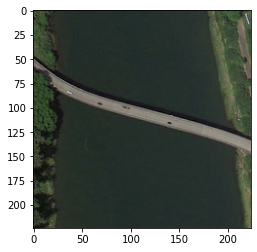

Human-annotated Caption:
 a long bridge is between the two mountains .
Generated Caption:
 the park is surrounded by a dense residential area .
BLEU score: 0.6865890479690392
_____________________________________
/content/drive/My Drive/data/raw/imgs/rsicd/playground_155.jpg


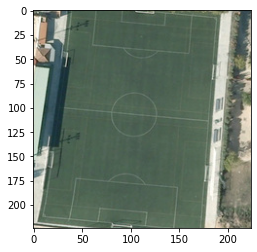

Human-annotated Caption:
 some trees are near a football field .
Generated Caption:
 there are many tall trees planted around the factory .
BLEU score: 0.7071067811865476
_____________________________________
/content/drive/My Drive/data/raw/imgs/rsicd/mountain_330.jpg


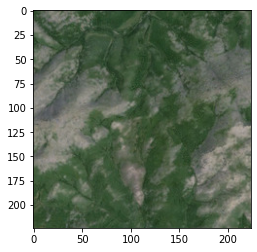

Human-annotated Caption:
 some part of the mountain is covered by vegetations while others are bare .
Generated Caption:
 the park is surrounded by a dense residential area .
BLEU score: 0.5169731539571706
_____________________________________
/content/drive/My Drive/data/raw/imgs/rsicd/port_121.jpg


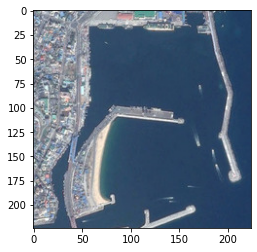

Human-annotated Caption:
 several boats are in a large port near many buildings .
Generated Caption:
 there are many tall trees planted around the playground .
BLEU score: 0.6529942057256104
_____________________________________
/content/drive/My Drive/data/raw/imgs/rsicd/mediumresidential_163.jpg


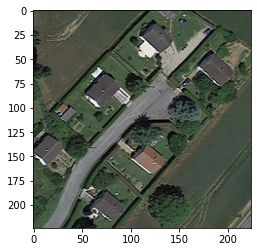

Human-annotated Caption:
 some buildings and many green trees are in a medium residential area .
Generated Caption:
 the park is surrounded by a dense residential area .
BLEU score: 0.6262844962765469
_____________________________________
/content/drive/My Drive/data/raw/imgs/rsicd/pond_185.jpg


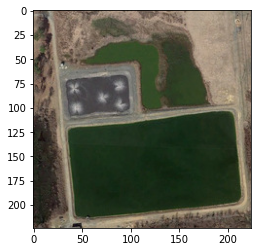

Human-annotated Caption:
 some green trees are near a rectangular pond and two irregular ponds .
Generated Caption:
 there are many tall trees planted around the factory .
BLEU score: 0.6262844962765469
_____________________________________
/content/drive/My Drive/data/raw/imgs/rsicd/park_10.jpg


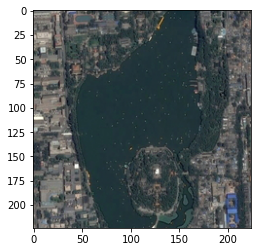

Human-annotated Caption:
 a lake with black water in the middle .
Generated Caption:
 many green trees are around two buildings .
BLEU score: 0.6865890479690392
_____________________________________
/content/drive/My Drive/data/raw/imgs/rsicd/beach_14.jpg


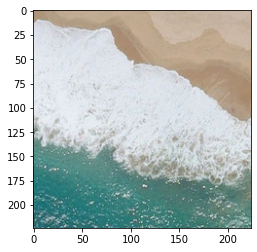

Human-annotated Caption:
 white waves are between green ocean and yellow beach .
Generated Caption:
 the storage in this factory is to oil .
BLEU score: 0.5623413251903491
_____________________________________
/content/drive/My Drive/data/raw/imgs/rsicd/bridge_160.jpg


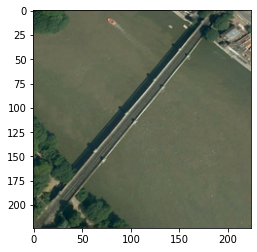

Human-annotated Caption:
 many green trees are in one side of a river with a bridge over it .
Generated Caption:
 the park is surrounded by a dense residential area .
BLEU score: 0.5946035575013605
_____________________________________


In [89]:
for z in range(10):
  pic = test_img[z]
  image = encoding_test[z]
  print(pic)
  x=plt.imread(pic)
  plt.imshow(x)
  plt.show()
  print("Human-annotated Caption:\n", test_descriptions[z][0])
  generated = generateCaption(image)
  print("Generated Caption:\n", generated)
  print("BLEU score:", 
        bleu_score.sentence_bleu(generated, test_descriptions[z][0].split()))

  print("_____________________________________")

In [0]:
encoding_test[0].shape

(2048,)